## Жиделев Сергей, РИ-401002, Вариант 7

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
from statsmodels.tsa.tsatools import detrend
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [3]:
df = pd.read_csv('Data//cursach//07.txt', sep = ' ', ).rename(columns={"-0.35793": 'Data'})
df.head(5)

,Data
0,-0.24496
1,0.10937
2,1.29380
3,1.38960
4,0.69561


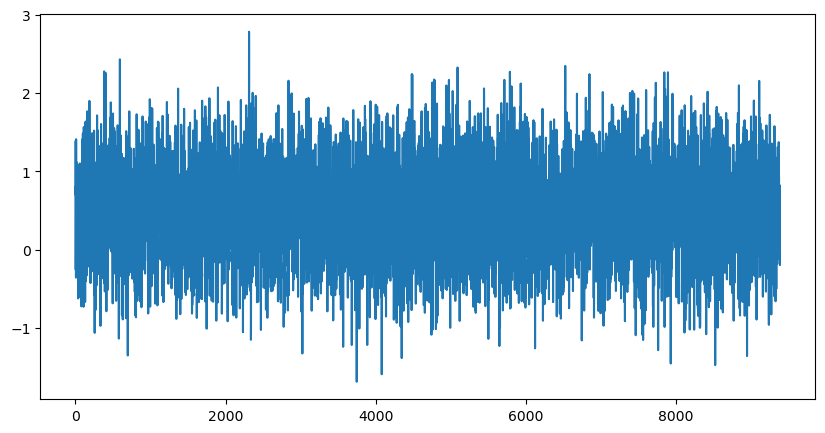

In [4]:
plt.figure(figsize = (10, 5))
plt.plot(df)

In [5]:
X = np.array(df['Data'])

### 1. Проверка ряда на стационарность

In [6]:
res = sm.tsa.stattools.kpss(df, nlags = 'auto')
print(f'p-value: {res[1]}')

p-value: 0.1


C:\Users\Shinik\AppData\Local\Temp\ipykernel_13616\683636322.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = sm.tsa.stattools.kpss(df, nlags = 'auto')


По тесту KPSS принимаем нулевую гипотезу о стационарности ряда

Посмотрим на периодограммы и спектрограммы исходного ряда

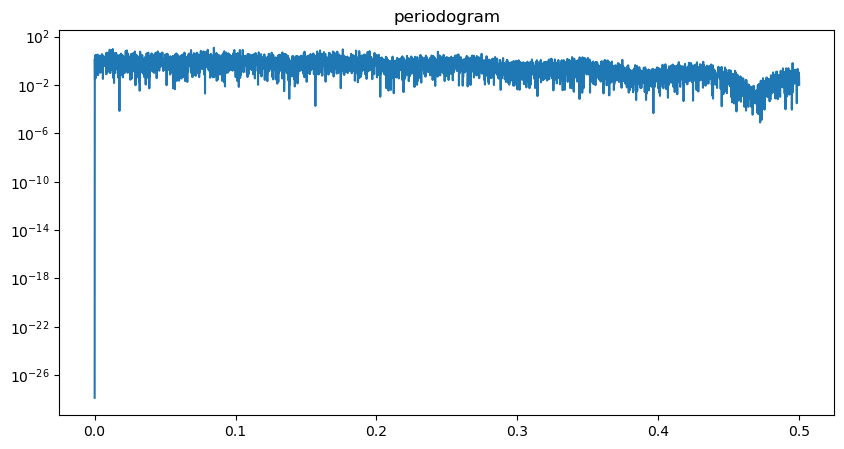

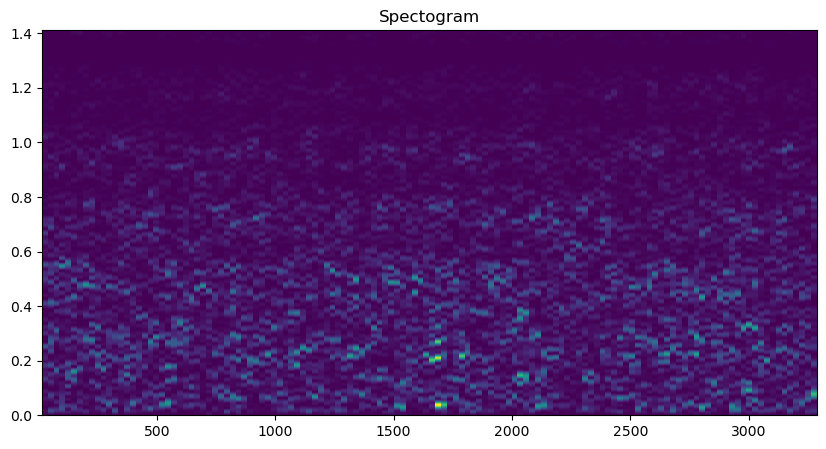

In [7]:
t = np.array(list(range(len(X))))
fs = 1/(X[1] - X[0])
f, tx, Sxx = signal.spectrogram(X, fs, nperseg = 150, noverlap = 80, nfft=4096)
pd, pdden = signal.periodogram(X) # периодограмма

analytic_signal = signal.hilbert(X)
inst_ampl = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase)/(2.0*np.pi)*fs)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))


plt.figure(figsize = (10, 5))
plt.semilogy(pd, pdden)
plt.title('periodogram')
plt.show()

plt.figure(figsize = (10, 5))
plt.pcolormesh(tx, f, Sxx, shading = 'auto')
plt.title('Spectogram')
plt.show()

Гилберт

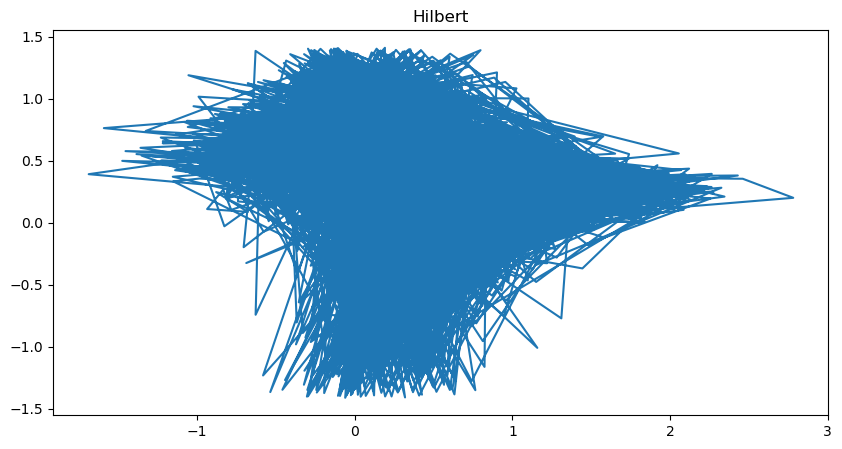

In [8]:
plt.figure(figsize = (10, 5))
plt.plot(X[1:], instantaneous_frequency[0:])
plt.title('Hilbert')
plt.show()

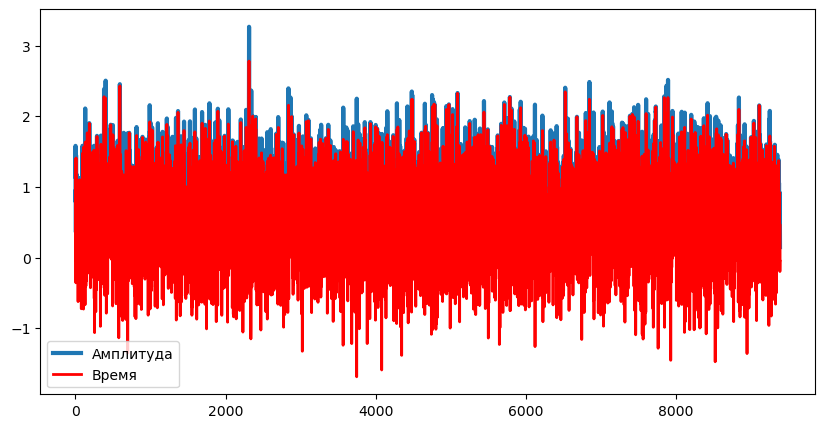

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(t[1:], inst_ampl[1:], label="Амплитуда", linewidth=3)
plt.plot(t[1:], X[1:], label="Время", linewidth=2, c = 'r')
plt.legend(loc="lower left")
plt.show()

### 2. Выделение тренда

Выделим тренд регрессией и сглаживанием

Регрессия

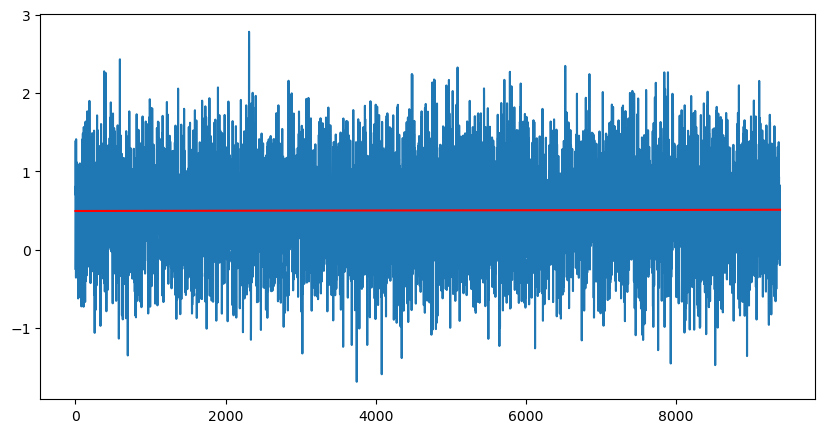

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


reg = LinearRegression().fit(t.reshape(-1, 1), X)
plt.figure(figsize=(10, 5))
plt.plot(t, X)
plt.plot(t, reg.predict(t.reshape(-1, 1)), c = 'r')

Сглаживание

In [11]:
def exp_smooth(x, a):
    w = [np.mean(x[0:2])]
    for i in range(1, len(x)):
        w.append((1 - a) * w[-1] + a * x[i])
    return w


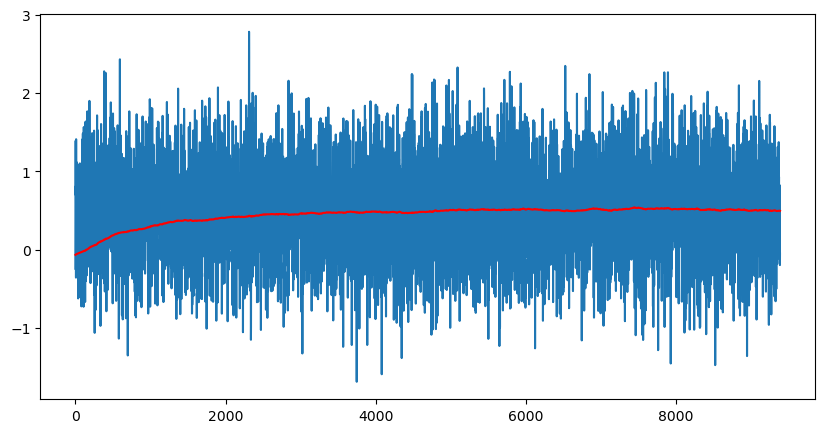

In [12]:
res = exp_smooth(X, 0.001)
plt.figure(figsize=(10, 5))
plt.plot(X)
plt.plot(res, c = 'r')
plt.show()

Взяв 1-й порядок, получим исходный сглаженный ряд, однако если взять порядок 1/100, то получится выделить тренд

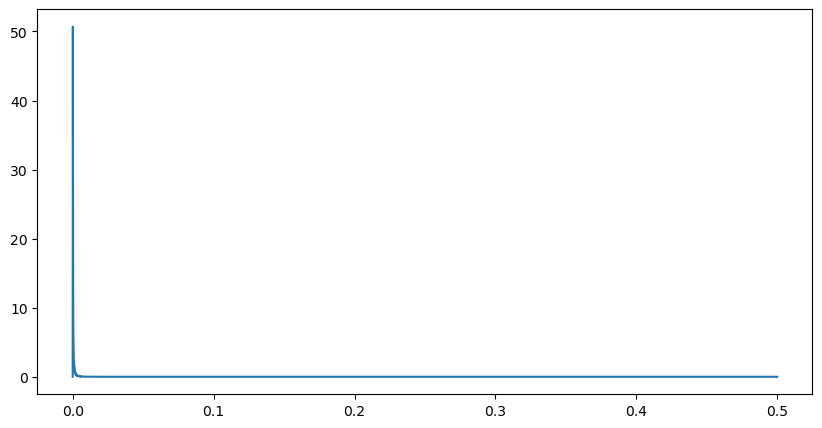

In [13]:
pd, pdden = signal.periodogram(np.array(res))
plt.figure(figsize = (10, 5))
plt.plot(pd, pdden)

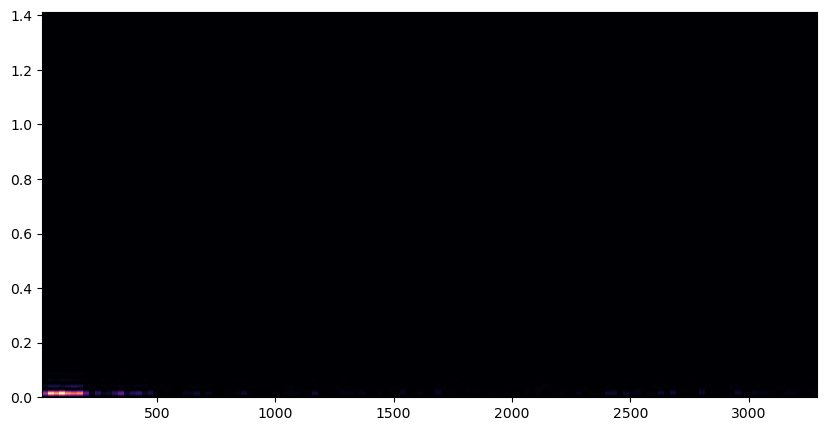

In [14]:
f, tx, Sxx = signal.spectrogram(np.array(res), fs, nperseg = 150, noverlap = 80, nfft=4096)
plt.figure(figsize = (10, 5))
plt.pcolormesh(tx, f, Sxx, shading = 'auto', cmap = 'magma')

### 3. Вейвлет-декомпозиция

Вейвлет-декомпозиция

In [15]:
import pywt

In [16]:
wvlt = 'dmey'
pywt.dwt_max_level(len(X), wvlt)

7

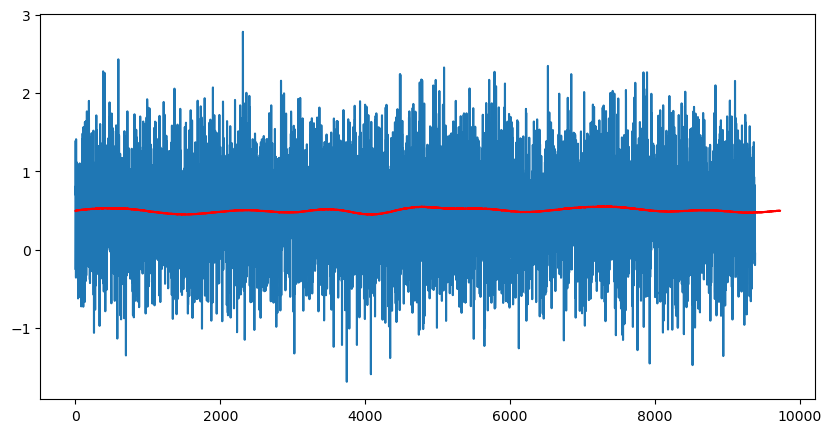

In [17]:
Mode = 'periodization'
res = pywt.wavedec(X, wvlt, mode=Mode, level=9)
res1 = pywt.waverec((res[0], None, None, None, None, None, None, None, None, None), wvlt, mode = Mode)

plt.figure(figsize = (10, 5))
plt.plot(X)
plt.plot(res1, c = 'r')
plt.show()

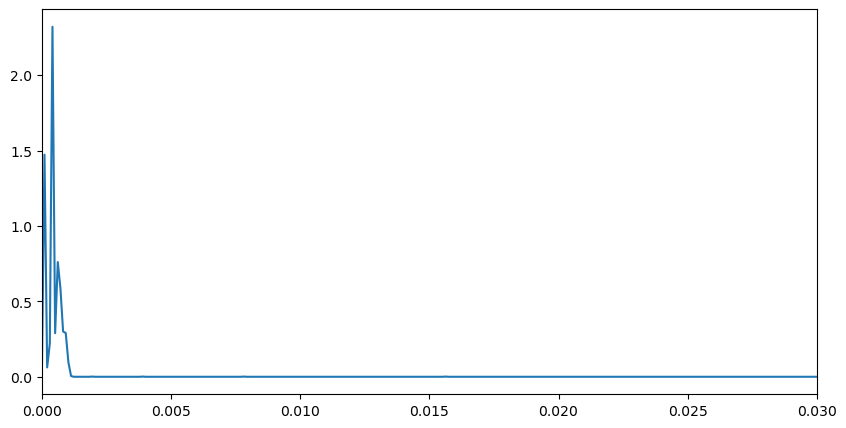

In [18]:
pd, pdden = signal.periodogram(res1)
plt.figure(figsize = (10, 5))
plt.xlim(0, 0.03)
plt.plot(pd, pdden)

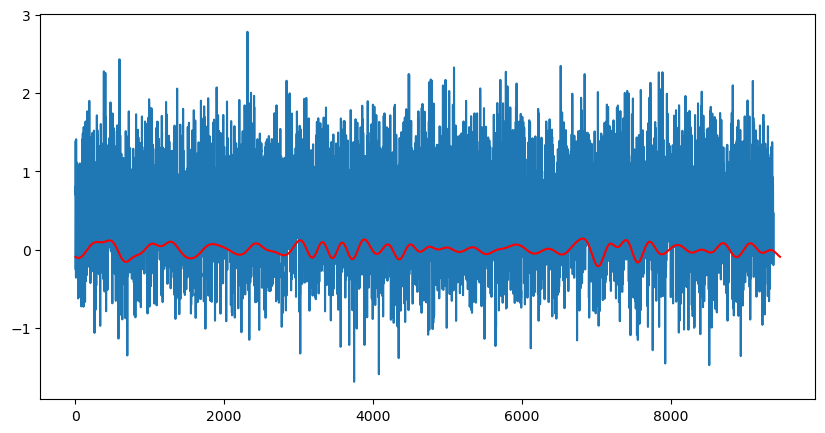

In [19]:
res = pywt.wavedec(detrend(X), wvlt, mode=Mode, level=9)
res1 = pywt.waverec((None, res[1], res[2], None, None, None, None, None, None, None), wvlt, mode = Mode)

plt.figure(figsize = (10, 5))
plt.plot(X)
plt.plot(res1, c = 'r')
plt.show()

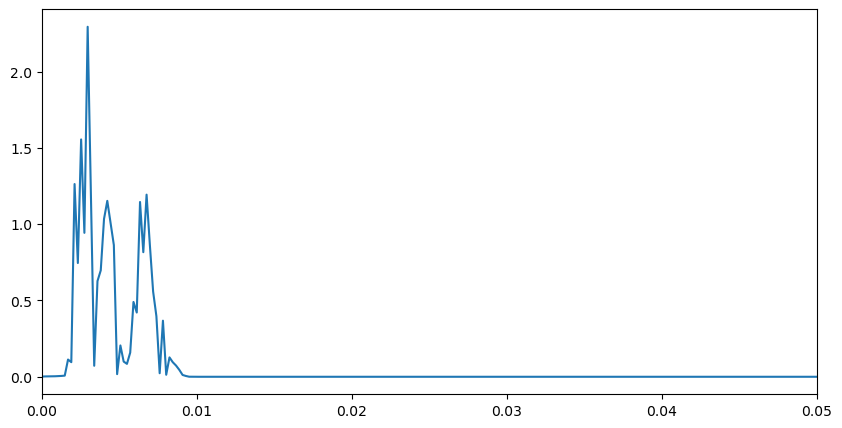

In [20]:
pd, pdden = signal.periodogram(res1, detrend=False, fs = 2.0)
plt.figure(figsize = (10, 5))
plt.xlim(0, 0.05)
plt.plot(pd, pdden)

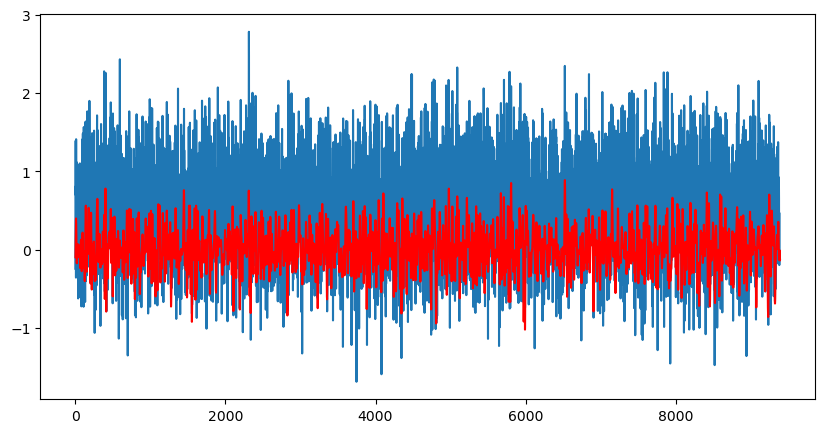

In [21]:
res1 = pywt.waverec((None, res[3], res[4], res[5], res[6], None, None, None), wvlt, mode = Mode)

plt.figure(figsize = (10, 5))
plt.plot(X)
plt.plot(res1, c = 'r')
plt.show()

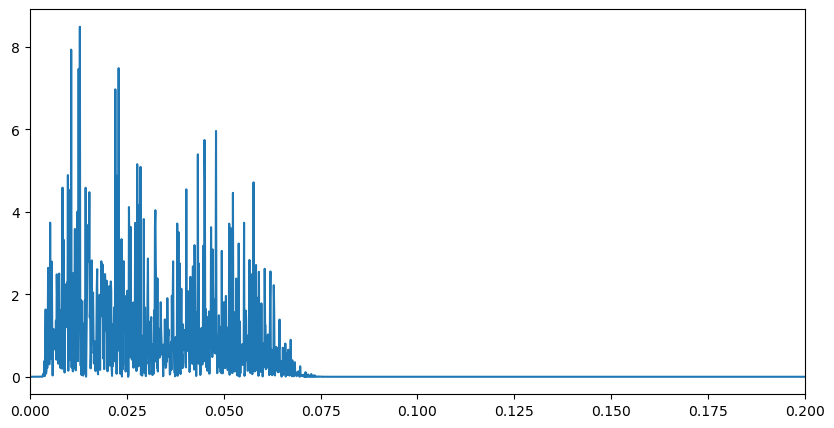

In [22]:
pd, pdden = signal.periodogram(res1)
plt.figure(figsize = (10, 5))
plt.xlim(0, 0.2)
plt.plot(pd, pdden)

### 4. Декомпозиция на аддитивные компоненты SSA-методом

SSA-метод

In [23]:
class SSA_dec:
    def __init__(self, F, L, I):
        self.F = F
        self.L = L
        self.I = I

    def __call__(self):
        A, U, V = self.SSA_modes(self.F, self.L)
        return self.SSA_group(A, U, V, len(self.F), self.I)
    
    def SSA_modes(self, F, L):
        N = len(F)
        K = N - L + 1
        X = np.ones((L, K))
    
        for k in range(L):
            j, m = k, k
            for i in range(j, K+m):
                X[k, i - j] = F[i]

        S = np.dot(X, X.T)
        U, A, _ = np.linalg.svd(S)
        V = np.dot(X.T, U)
    
        return (A, U, V)

    def SSA_group(self, A, U, V, N, I):
        L = len(A)
        V = V.transpose()
        K = N - L + 1
        
        Z = np.dot(U[:, I], V[I, :])
    
        lv = []
        L_min = min(L, K)
        K_max = max(L, K)
    
        for k in range(0, L_min - 1):
            s = 0
            for i in range(k+1):
                s += Z[i, k - i]
            lv.append(s/(k+1))

        for k in range(L_min - 1, K_max):
            s = 0
            
            for i in range(L_min):
                s += Z[i, k - i]
            lv.append(s/(L_min))
    
        for k in range(K_max, N):
            s = 0
    
            for i in range(k - K_max + 1, N - K_max + 1):
                s += Z[i, k - i]
            lv.append(s/(N - k))

        return lv

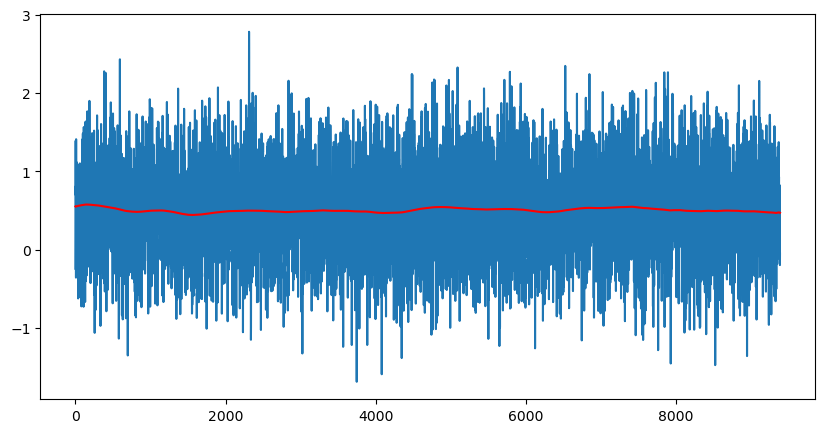

In [24]:
L = 500
I = [0]
F = X

plt.figure(figsize = (10, 5))
ex = SSA_dec(F, L, I)()
plt.plot(F)
plt.plot(ex, c = 'r')

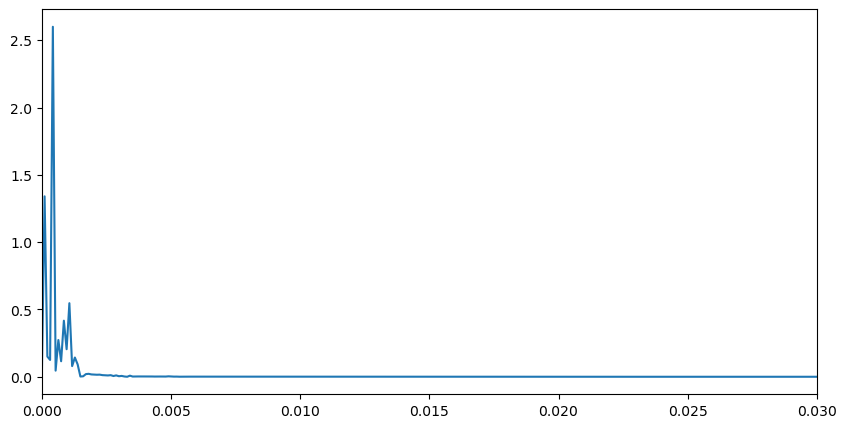

In [25]:
pd, pdden = signal.periodogram(ex)
plt.figure(figsize = (10, 5))
plt.xlim(0, 0.03)
plt.plot(pd, pdden)

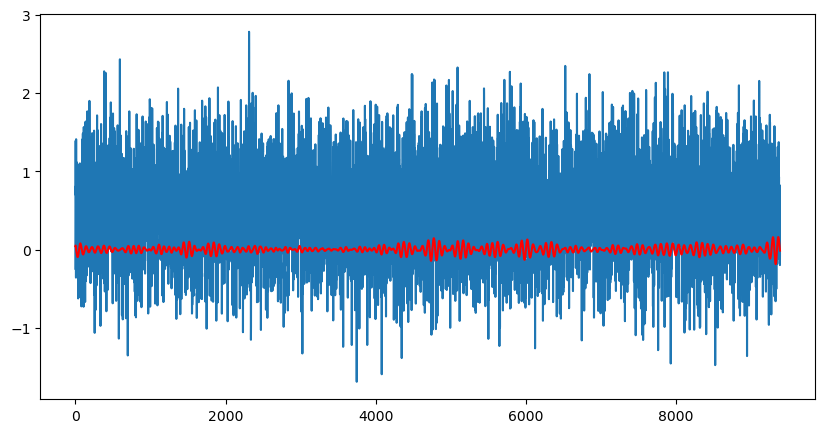

In [26]:
L = 500
I = [4, 5]
F = X

plt.figure(figsize = (10, 5))
ex = SSA_dec(detrend(F), L, I)()
plt.plot(F)
plt.plot(ex, c = 'r')

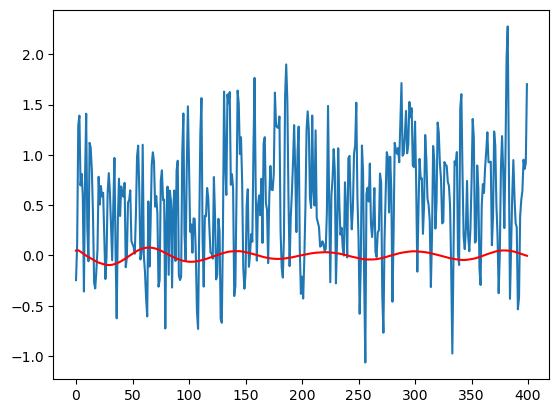

In [27]:
plt.plot(F[:400])
plt.plot(ex[:400], c = 'r')
plt.show()

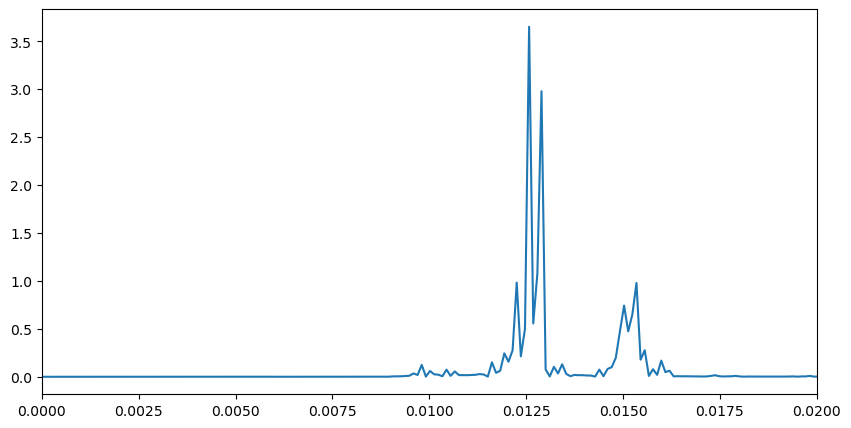

In [28]:
pd, pdden = signal.periodogram(ex)
plt.figure(figsize = (10, 5))
plt.xlim(0, 0.02)
plt.plot(pd, pdden)

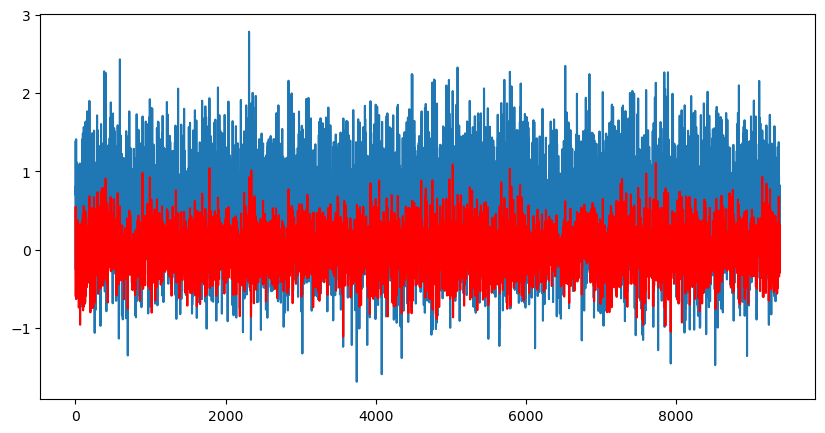

In [29]:
L = 500
I = [i for i in range(20, 100)]
F = X

plt.figure(figsize = (10, 5))
ex = SSA_dec(F, L, I)()
plt.plot(F)
plt.plot(ex, c = 'r')

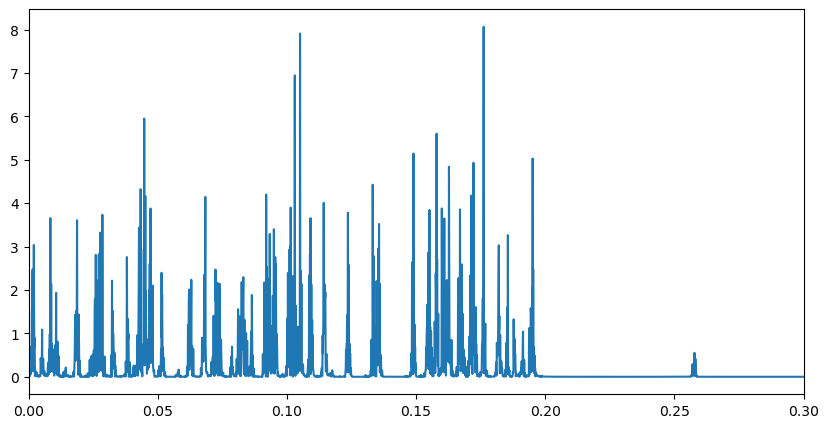

In [30]:
pd, pdden = signal.periodogram(ex)
plt.figure(figsize = (10, 5))
plt.xlim(0, 0.3)
plt.plot(pd, pdden)

### 5. Прогноз данных моделью ARIMA

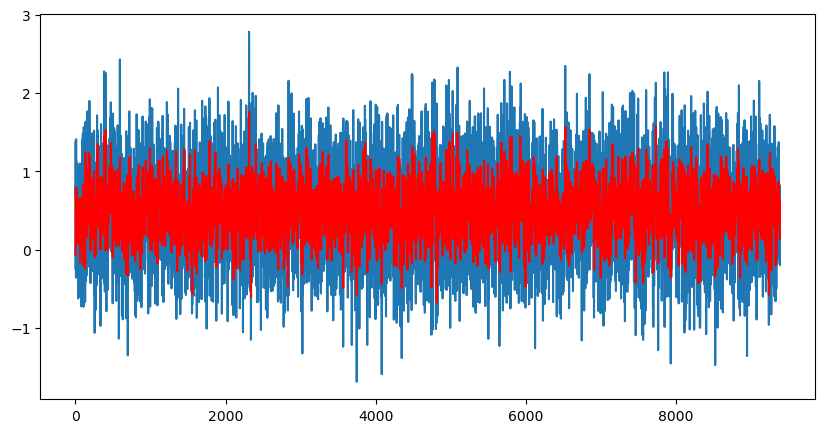

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.tsatools import detrend


sgl = np.array(exp_smooth(X, 0.3))
plt.figure(figsize = (10, 5))
plt.plot(X)
plt.plot(sgl, c = 'r')

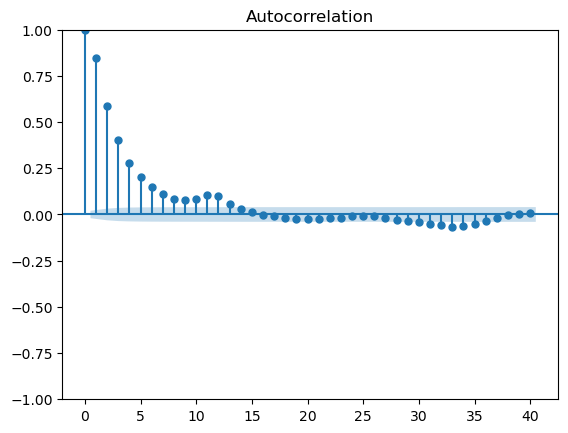

<Figure size 1000x500 with 0 Axes>

In [32]:
plot_acf(sgl)
plt.figure(figsize = (10, 5))
plt.show()

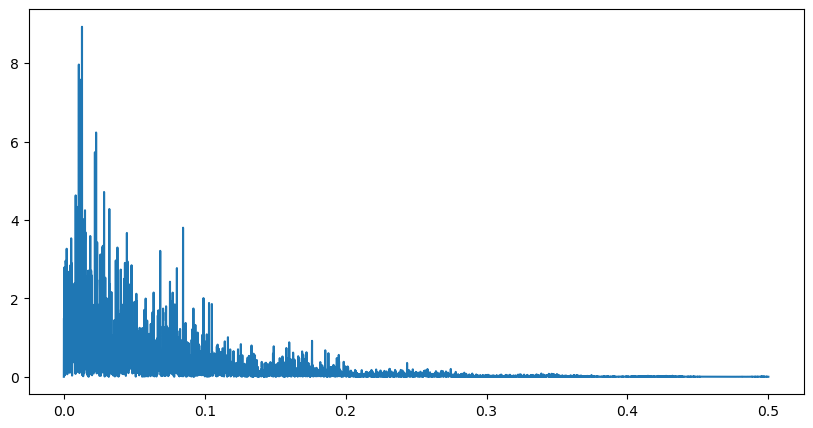

In [33]:
pd, pdden = signal.periodogram(sgl)
plt.figure(figsize = (10, 5))
plt.plot(pd, pdden)

Байесовский критерий устраняет проблему переобучения, штрафуя увеличение числа параметров модели. Тесно связан с критерием Акаике, но в случае байесовского критерия увеличение параметров штрафуется строже.

In [34]:
def param(x):
    arr = []
    for i in range(1, 5):
        for j in range(5):
            for m in range(1, 6):
                arimaz = ARIMA(x, order = (i, j, m))
                model = arimaz.fit()
                arr.append(model)


    min_bic = 9000000
    for i in arr:
        if i.bic < min_bic:
            min_bic = i.bic
            mod = i

    return mod

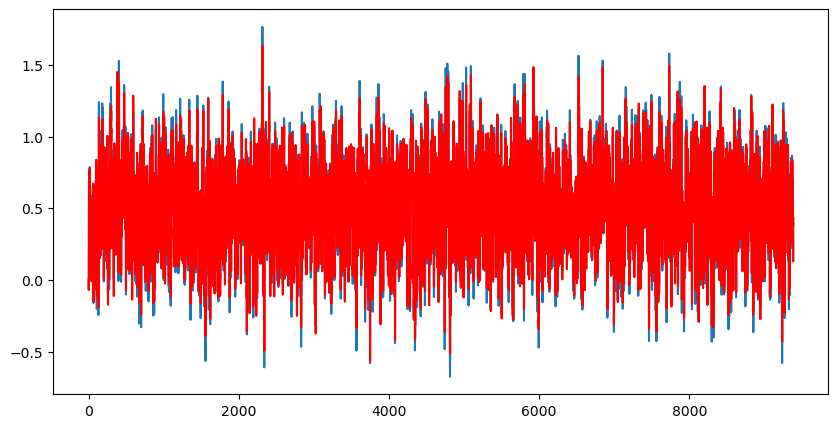

In [459]:
t = np.linspace(0, len(sgl), len(sgl))
a = param(sgl)
plt.figure(figsize = (10, 5))
plt.plot(t, sgl)
plt.plot(t, a.predict(0, len(sgl)-1), c = 'red')
plt.show()

In [460]:
a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9384
Model:                 ARIMA(4, 1, 3)   Log Likelihood                5392.704
Date:                Wed, 29 May 2024   AIC                         -10769.409
Time:                        00:52:53   BIC                         -10712.236
Sample:                             0   HQIC                        -10749.995
                               - 9384                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4325      0.011    -38.741      0.000      -0.454      -0.411
ar.L2          0.7420      0.011     65.914      0.000       0.720       0.764
ar.L3          0.1537      0.012     13.310      0.000       0.131       0.176
ar.L4         -0.1699      0.011    -15.804      0.000      -0.191      -0.149
ma.L1          0.9190      0.004    244.087      0.000       0.912       0.926
ma.L2         -0.9579      0.002   -456.358      0.000      -0.962      -0.954
ma.L3         -0.9533      0.004   -261.528      0.000      -0.960      -0.946
sigma2         0.0185      0.000     67.226      0.000       0.018       0.019
===================================================================================
Ljung-Box (L1) (Q):                   2.43   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.12   Prob(JB):                         0.39
Heteroskedasticity (H):               1.05   Skew:                            -0.01
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6. Прогноз данных моделью SSA-R

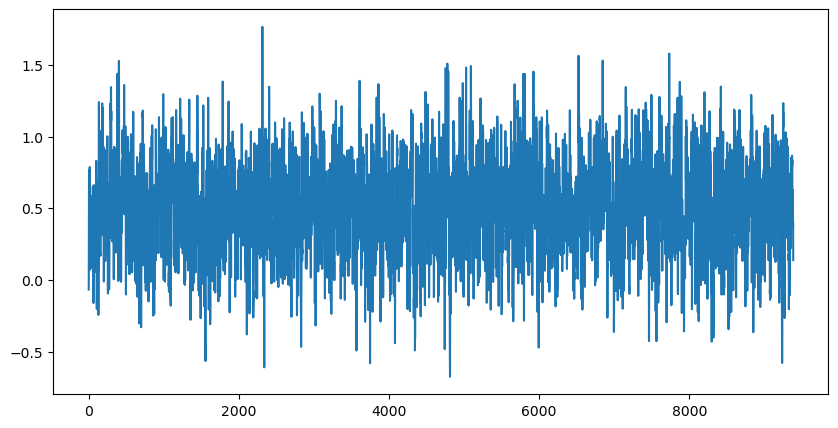

In [461]:
plt.figure(figsize=(10, 5))
plt.plot(sgl)

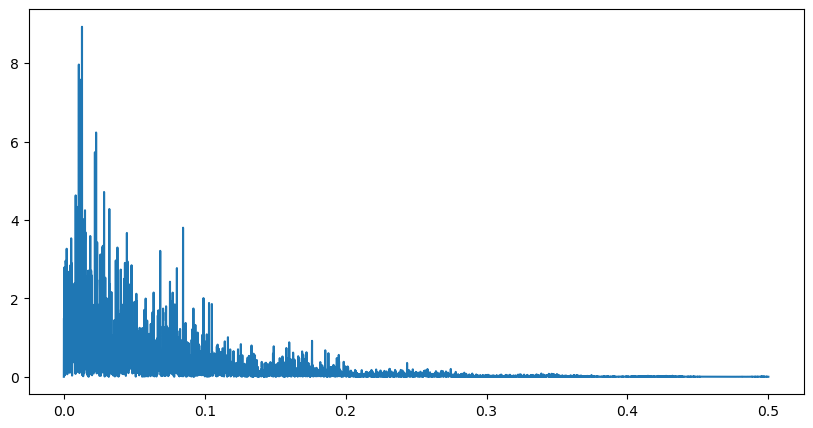

In [462]:
pd, pdden = signal.periodogram(sgl)
plt.figure(figsize=(10, 5))
plt.plot(pd, pdden)

Сгладим ряд

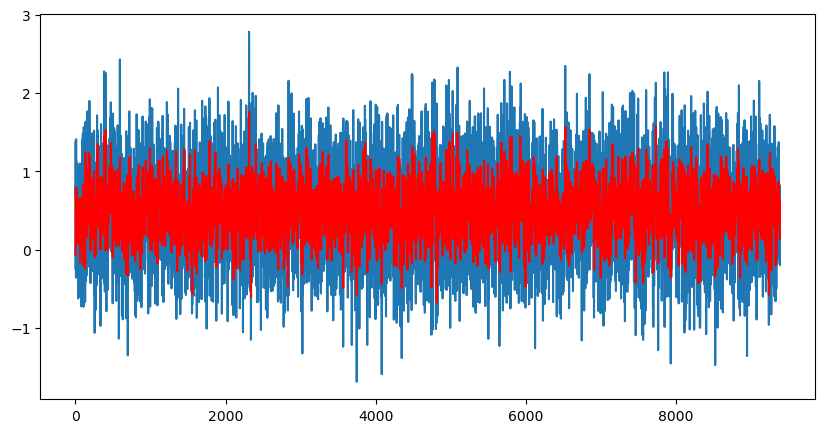

In [463]:
res = exp_smooth(X, 0.3)
plt.figure(figsize=(10, 5))
plt.plot(X)
plt.plot(res, c = 'r')
plt.show()

Визуализируем периодограмму после сглаживания

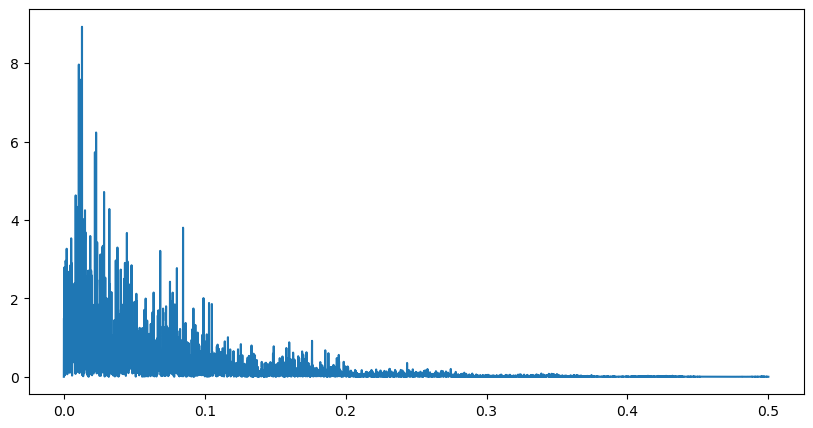

In [464]:
pd, pdden = signal.periodogram(res)
plt.figure(figsize=(10, 5))
plt.plot(pd, pdden)

In [465]:
def SSA_modes(F, L):
    N = len(F)
    K = N - L + 1
    X = np.ones((L, K))
    
    for k in range(L):
        j, m = k, k
        for i in range(j, K+m):
            X[k, i - j] = F[i]

    S = np.dot(X, X.T)
    U, A, _ = np.linalg.svd(S)
    V = np.dot(X.T, U)
    
    return (A, U, V)

def SSA_group(A, U, V, N, I):
    L = len(A)
    V = V.transpose()
    K = N - L + 1
    
    Z = np.dot(U[:, I], V[I, :])

    lv = []
    L_min = min(L, K)
    K_max = max(L, K)
    
    for k in range(0, L_min - 1):
        s = 0
        for i in range(k+1):
            s += Z[i, k - i]
        lv.append(s/(k+1))

    for k in range(L_min - 1, K_max):
        s = 0
        
        for i in range(L_min):
            s += Z[i, k - i]
        lv.append(s/(L_min))

    for k in range(K_max, N):
        s = 0

        for i in range(k - K_max + 1, N - K_max + 1):
            s += Z[i, k - i]
        lv.append(s/(N - k))

    return lv

def SSA_R(A, U, N, M, I, res):
    vu = np.linalg.norm(U[-1, I])
    L = len(A)
    R = np.sum(U[L - 1, I] * U[0:L - 1, I], 1)
    R = R / (1 - vu * vu)
    # lv = list(F)
        
    for i in range(N, N + M - 1):
        s = 0
        for j in range(L - 1):
            s += R[j]*res[i-j-1]
        res = np.append(res, s)
    
    return res

Ретроспективный прогноз на 1024 точки

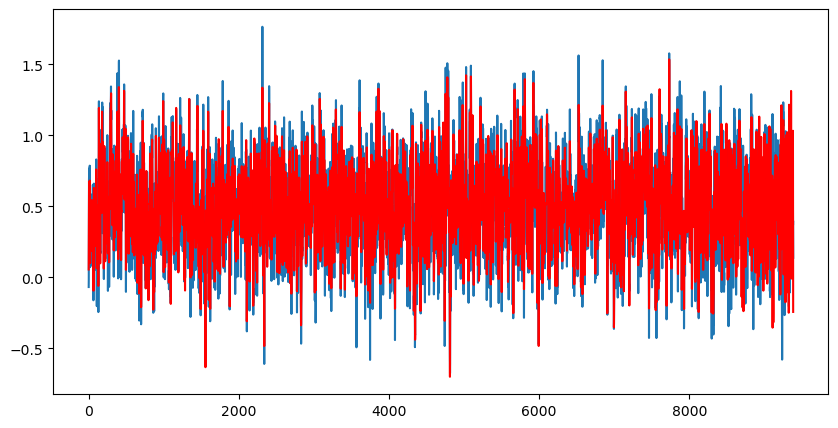

In [526]:
res1 = res[:-1024]
A, U, V = SSA_modes(res1, 400)
I = [i for i in range(0, 100)]
rec = SSA_group(A, U, V, len(res1), I)
M = 1024
pred = SSA_R(A, U, len(res1), M, I, rec)

plt.figure(figsize = (10, 5))
plt.plot(res)
plt.plot(pred, c = 'r')
plt.show()

Прогноз на 1024 точки вперёд

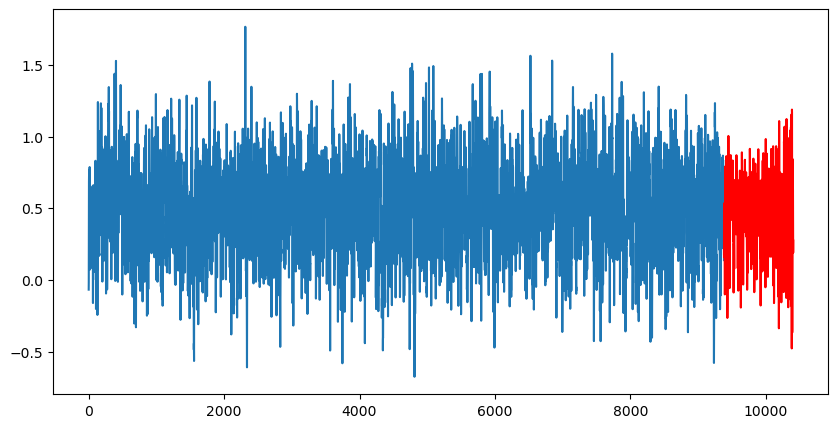

In [527]:
res1 = res[:]
A, U, V = SSA_modes(res1, 200)
I = [i for i in range(0, 50)]
rec = SSA_group(A, U, V, len(res1), I)
M = 1024
pred = SSA_R(A, U, len(res1), M, I, rec)

plt.figure(figsize = (10, 5))
plt.plot(res1)
plt.plot(np.r_[len(pred)-M:len(pred)],pred[-M:], c = 'r')
plt.show()

### 7. Прогноз данных с помощью нейросети

In [528]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [529]:
X = np.array(res)
X = X.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

F_tr, F_test = X[:len(X)-2048].reshape(-1, 1), X[len(X)-2248:].reshape(-1, 1)

data_gen = TimeseriesGenerator(F_tr, F_tr,
 length=100, sampling_rate=1,
 batch_size=len(F_tr))

batch_0 = data_gen[0]
x, y = batch_0 
print(x.shape) 
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy=y
print(xx.shape) 
print(yy.shape) 

m = 100

model = Sequential()
model.add(LSTM(units=m, return_sequences=True, input_shape=(1, 100)))
model.add(Dropout(0.3))
model.add(LSTM(units=m, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=m))
model.add(Dropout(0.4))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

(7236, 100, 1)
(7236, 1, 100)
(7236, 1)


In [530]:
len(X)

9384

In [531]:
model.fit(xx, yy, epochs = 200)

Epoch 1/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0523
Epoch 2/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144
Epoch 3/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0098
Epoch 4/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092
Epoch 5/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080
Epoch 6/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075
Epoch 7/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071
Epoch 8/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0065
Epoch 9/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0069
Epoch 10/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0064
Epoch 11/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061
Epoch 12/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0060
Epoch 13/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055
Epoch 14/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055
Epoch 15/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


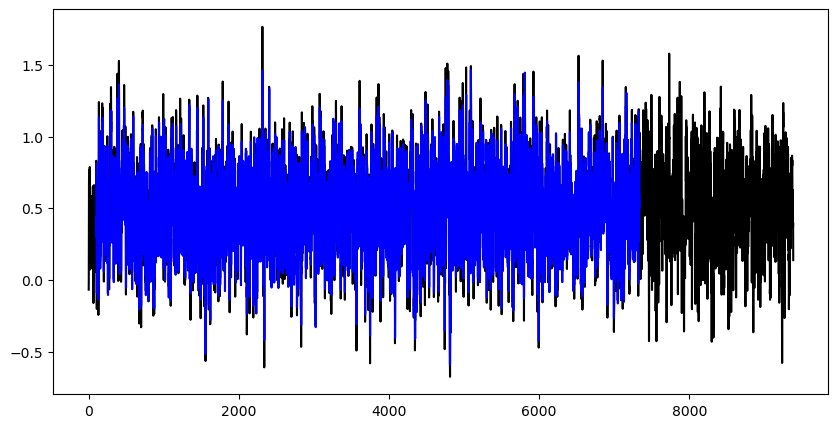

In [532]:
trainPredict = model.predict(xx)
trainPredict = scaler.inverse_transform(trainPredict)
plt.figure(figsize = (10, 5))
plt.plot(res, 'k')
plt.plot(np.r_[100:len(X) - len(F_test) + 200], trainPredict, 'b')
plt.show()

In [533]:
data_gen = TimeseriesGenerator(F_test, F_test,
 length=100, sampling_rate=1,
 batch_size=len(F_test))
batch_0 = data_gen[0]
x, y = batch_0
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y
print(xx.shape)
print(yy.shape) 

(2148, 1, 100)
(2148, 1)


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


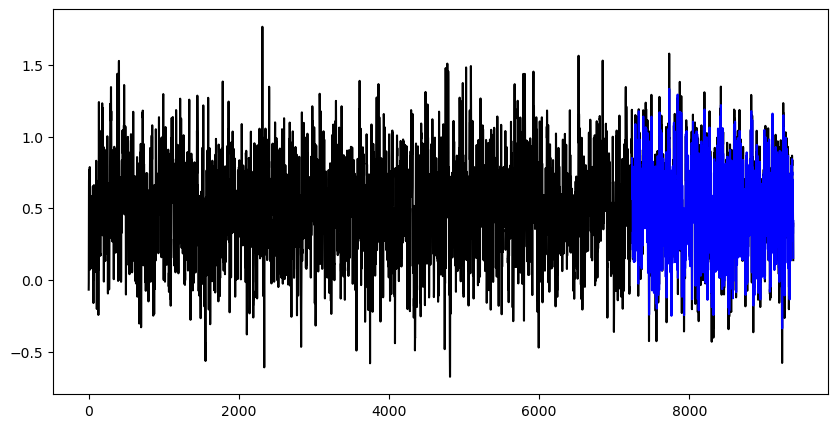

In [534]:
testPredict = model.predict(xx)
testPredict = scaler.inverse_transform(testPredict)
plt.figure(figsize = (10, 5))
plt.plot(res, 'k')
plt.plot(np.r_[len(X) - len(testPredict):len(X)], testPredict, 'b')
plt.show()